# Homework 07 — IANNwTF
## Group 27
Deadline: Dec 12, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

In [1]:
import numpy as np
import tensorflow as tf

# Data

In [2]:
def integration_task(seq_len, num_samples):
  '''
  Generator function that yields a random noise signal of the size seq_len
  and a target (if the sum of the noise signal is greater
  or smaller than 1) for num_samples.

  Args:
  seq_len (int): sequence length, i.e. number of time steps
  num_samples (int): number of samples to be generated
  '''
  for sample in range(num_samples):
    noise = np.random.normal(size=seq_len)
    target = int(np.sum(noise,axis=-1)> 1)
    noise = np.expand_dims(noise,axis=-1)
    target = np.expand_dims(target,axis=-1)
    yield (noise, target)

In [3]:
def my_integration_task():
  '''
  Wrapper function for the generator integration_task(seq_len, num_samples)
  defined above, which internally iterates to integration_task
  with a specified seq_len and num_samples and yields the function’s yield.
  '''
  seq_len = 25
  num_samples = 80000
  yield from integration_task(seq_len, num_samples)

In [4]:
# create the Tensorflow Dataset by passing on the wrapper generator
ds = tf.data.Dataset.from_generator(my_integration_task, output_types=(tf.float32,tf.float32))                    

In [5]:
batch_size = 64

def prepare_data(ds):
  '''
  Data pipeline that performs shuffling, batching, and prefetching on the given dataset.

  Args:
  ds (tf.data.Dataset): the dataset that the preprocessing is to be performed on
  '''
  ds = ds.shuffle(1000).batch(batch_size).prefetch(20)
  return ds


In [6]:
ds = prepare_data(ds)

In [7]:
for element in ds.take(1):
  print(element[0].shape, element[1].shape)

(64, 25, 1) (64, 1)


# Network

In [8]:
class LSTMCell(tf.keras.layers.Layer):
  def __init__(self, units):
    '''
    Constructor for a LSTM Cell.

    Args:
    units (int): number of units
    '''
    super(LSTMCell, self).__init__()
    
    self.units = units

    self.forget_gate = tf.keras.layers.Dense(units, activation="sigmoid", bias_initializer='ones')
    self.input_gate = tf.keras.layers.Dense(units, activation="sigmoid")
    self.output_gate = tf.keras.layers.Dense(units, activation="sigmoid")
    self.candidates = tf.keras.layers.Dense(units, activation="tanh",kernel_initializer='orthogonal')


  def call(self, x, states):
    '''
    Args:
    x (tf.Tensor): input for a single time step
    states (tf.Tensor, tf.Tensor) : a tuple containing hidden state and cell state
    '''
    hidden_state, cell_state = states # (old) hidden state and (old) cell state
    inputs = tf.concat((x, hidden_state), axis=-1) # concatenate hidden state and inputs

    cell_state = cell_state * self.forget_gate(inputs)

    # next step: input gate
    cell_state = cell_state + self.candidates(inputs) * self.input_gate(inputs)

    # last step: output gate
    hidden_state = self.output_gate(inputs) * tf.nn.tanh(cell_state)

    return hidden_state, cell_state

  

In [9]:
class LSTMLayer(tf.keras.layers.Layer):
  def __init__(self, cell):
    '''
    Constructor for a LSTM Layer containing one LSTM Cell.
    
    Args:
    cell (LSTMCell): the LSTMCell the layer consists of.
    '''
    super(LSTMLayer, self).__init__()
            
    self.cell = cell

  def zero_states(self, batch_size):
    '''
    Resets the states of the LSTM to zero given the bach size.

    Args:
    batch_size (int)

    Returns:
    a tuple of states of the appropriate size filled with zeros.
    '''
    return (tf.zeros((batch_size, self.cell.units)), tf.zeros((batch_size, self.cell.units)))

  def call(self, x, states):
    '''
    Takes the input over multiple time steps and returns
    the outputs over multiple time steps.

    Args:
    x (tf.Tensor of shape  [batch size, seq_len, input_size]): input
    states (tuple) : a tuple containing hidden state and cell state

    Returns:
    output of the layer, of shape [batch size, seq len, output size]
    '''
    num_timesteps = tf.shape(x)[1] # second dimension of x is sequence length

    unrolled = tf.TensorArray(dtype=tf.float32, size=num_timesteps)
    # iterate over timesteps
    for t in tf.range(num_timesteps):
      hidden_states, _ = self.cell(x[:,t,:], states)
      unrolled = unrolled.write(t, hidden_states)

    outputs = tf.transpose(unrolled.stack(), perm=[1,0,2])

    return outputs


In [10]:
class MyModel(tf.keras.Model):
  
  def __init__(self):
    '''
    Constructor for the LSTM Model.
    '''
    super(MyModel, self).__init__()

    self.read_in =  tf.keras.layers.Dense(64, activation="sigmoid")
    self.read_in_2 = tf.keras.layers.Dense(32)
    self.lstm_cell = LSTMCell(units=2)
    self.lstm = LSTMLayer(self.lstm_cell)
    self.out_layer = tf.keras.layers.Dense(1, activation="sigmoid") # output layer with one unit for a binary classification task

  def call(self, x):
    '''
    Args:
    x (tf.Tensor) : input to the model
    '''
    batch_size = tf.shape(x)[0] # needed for zero_states

    zero_states = self.lstm.zero_states(batch_size=batch_size) # reset LSTM states

    out = self.read_in(x)
    out = self.read_in_2(out)
    out = self.lstm(out, zero_states)
    out = self.out_layer(out)

    return out

In [11]:
# training step
@tf.function
def train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(targets, predictions[:,-1,:])
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    logs = {}
    accuracy_metric.update_state(targets, predictions[:,-1,:])
    logs[accuracy_metric.name] = accuracy_metric.result()
    loss_metric.update_state(loss)
    logs["loss"] = loss_metric.result()
    return logs

In [12]:
tf.keras.backend.clear_session()

# hyperparameters
epochs = 40
learning_rate = 0.001

# initialize the model
model = MyModel()
# initialize the loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()
# initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Metrics
accuracy_metric = tf.keras.metrics.BinaryAccuracy()
loss_metric = tf.keras.metrics.Mean()
hist = {'loss': [], 'binary_accuracy': []}

def reset_metrics(metrics):
    # utility function to reset the state of metrics
    for metric in metrics:
        metric.reset_state()

# training
for epoch in range(epochs):
    reset_metrics([accuracy_metric,loss_metric])
    for inputs, targets in ds:
        logs = train_step(model, inputs, targets, loss_fn, optimizer, loss_metric, accuracy_metric)
    for key, value in logs.items():
        hist[key].append(value)
        
    if epoch % 5 == 0:
        print(f"...Training results at the end of epoch {epoch}:")
        for key, value in logs.items():
            print(f"...{key}: {value:.4f}")
        print("\n")
        

...Training results at the end of epoch 0:
...binary_accuracy: 0.5871
...loss: 0.6708


...Training results at the end of epoch 5:
...binary_accuracy: 0.5913
...loss: 0.6687


...Training results at the end of epoch 10:
...binary_accuracy: 0.5920
...loss: 0.6680


...Training results at the end of epoch 15:
...binary_accuracy: 0.5925
...loss: 0.6685


...Training results at the end of epoch 20:
...binary_accuracy: 0.5925
...loss: 0.6681


...Training results at the end of epoch 25:
...binary_accuracy: 0.5938
...loss: 0.6673


...Training results at the end of epoch 30:
...binary_accuracy: 0.5932
...loss: 0.6679


...Training results at the end of epoch 35:
...binary_accuracy: 0.5918
...loss: 0.6677




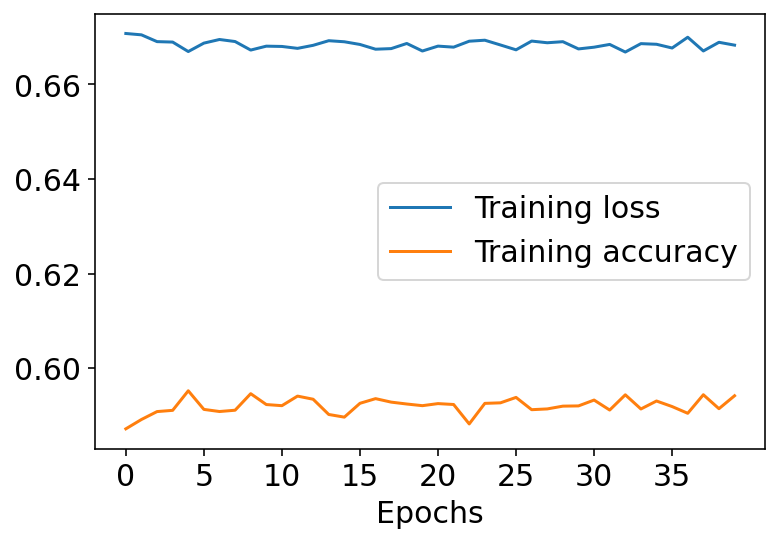

In [13]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 15
plt.plot(hist['loss'], label='Training loss')
plt.plot(hist['binary_accuracy'], label='Training accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(epochs, step=5))
plt.legend()
plt.show()